# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:

Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Подготовка данных

### Приведение данных к нужным типам и исправление ошибок

#### Датасет со звонками

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Минимальный звонок 0 минут (пропущенные звонки), максимальный - 38 минут. Аномально долгих звонков не выялено, в среднем звонок длится около 7 минут.

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Видим, что в датасете нет пропусков.
Необходимо привести столбец `call_date` к типу дата, а также округлить значения из столбца `duration` в большую сторону, т.к. это сказано в примечании к проекту. При округлении получим целые значения, так что приведем  данные к целочисленному типу. Не будем удалять звонки с нулевой продолжительностью, т.к. так обозначаются пропущенные звонки.

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [7]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [8]:
display(calls.head(), calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


None

#### Датасет с интернетом

In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Минимальная сессия в интернете составила 0 мб, это является аномалией, т.к. какая-то часть от мегабайта должна быть израсходована при загрузке страницы. Максимальная сессия составляет 1724 мб, что не является аномалией, такое количество трафика можно израсходовать, напрмер, смотря видео. В среднем клиенты расходовали 370 мб. за сессию.

<AxesSubplot:>

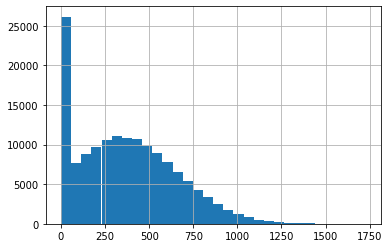

In [11]:
internet['mb_used'].hist(bins=30)

In [12]:
len(internet.query('mb_used == 0'))

19598

In [13]:
internet = internet.query('mb_used != 0')

In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    129798 non-null  int64  
 1   id            129798 non-null  object 
 2   mb_used       129798 non-null  float64
 3   session_date  129798 non-null  object 
 4   user_id       129798 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.9+ MB


В таблице нет пропусков. Видим, что необходимо привести столбец `session_date` к формату даты.

In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    129798 non-null  int64         
 1   id            129798 non-null  object        
 2   mb_used       129798 non-null  float64       
 3   session_date  129798 non-null  datetime64[ns]
 4   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.9+ MB


#### Датасет с сообщениями

In [17]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков нет, столбец `message_date` приводим к формату даты.

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [20]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### Датасет с тарифами

In [21]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

Работая над пунктом 2.2.4, увидела необходимость присоеденить к общей таблице датасет с тарифами. Для этого нужно, чтобы столбцы назывались одинаково.

In [23]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица отображает текстовое описание тарифов. Менять ничего не будем.

#### Датасет с пользователями

In [24]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [25]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Видим пропуски в столбце `churn_date`. Согласно описанию данных в этом столбце содержится дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Значит 38 клиентов из выборки перестали пользоваться тарифом. Заполнять пропуски не будем. Приведем столбцы `churn_date` и `reg_date` к формату даты.

In [26]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Расчет показателей по месяцам

#### Количество сделанных звонков и израсходованных минут разговора

In [28]:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [29]:
calls_total = calls.groupby(['user_id', 'month']).agg({'id': 'count', 'duration': 'sum'}).reset_index()
calls_total.head()

,user_id,month,id,duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [30]:
calls_total = calls_total.rename(columns={'id': 'calls_per_month', 'duration': 'total_duration'})
calls_total.head()

,user_id,month,calls_per_month,total_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


#### Количество отправленных сообщений

In [31]:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [32]:
messages_total = (
    messages
    .groupby(['user_id', 'month'])
    .agg({'id': 'count'})
    .reset_index()
    .rename(columns={'id': 'messages_per_month'})
)
messages_total.head()

,user_id,month,messages_per_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Объем израсходованного интернет-трафика

In [33]:
internet['month'] = internet['session_date'].dt.month
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


In [34]:
internet_total = (
    internet
    .groupby(['user_id', 'month'])
    .agg({'mb_used': 'sum'})
    .reset_index()
    .rename(columns={'mb_used': 'mb_per_month'})
)
internet_total.head()

,user_id,month,mb_per_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


#### Помесячная выручка с каждого пользователя

In [35]:
# поочередно присоеденим к датасету со сгруппированными звонками
# датасеты с сообщениями и интернетом
data_total = calls_total.merge(messages_total, on=['user_id', 'month'], how='outer')
data_total.head()

,user_id,month,calls_per_month,total_duration,messages_per_month
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0


In [36]:
data_total = data_total.merge(internet_total, on=['user_id', 'month'], how='outer')
data_total.head()

,user_id,month,calls_per_month,total_duration,messages_per_month,mb_per_month
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91


In [37]:
# а также присоеденим датасет с пользователями, чтобы 
# на основании него просоеденить информацию по тарифу
data_total = data_total.merge(users, on='user_id', how='outer')
data_total.head()

,user_id,month,calls_per_month,total_duration,messages_per_month,mb_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.0,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.0,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.0,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.0,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.0,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [38]:
data_total = data_total.merge(tariffs, on='tariff', how='outer')
data_total.head()

,user_id,month,calls_per_month,total_duration,messages_per_month,mb_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [39]:
# посмотрим на получившуюся таблицу
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   calls_per_month        3174 non-null   float64       
 3   total_duration         3174 non-null   float64       
 4   messages_per_month     2717 non-null   float64       
 5   mb_per_month           3201 non-null   float64       
 6   age                    3216 non-null   int64         
 7   churn_date             189 non-null    datetime64[ns]
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff                 3216 non-null   object        
 13  mes

In [40]:
# посмтотрим, почему появились пропуски
data_total[data_total['month'].isna() == True]

,user_id,month,calls_per_month,total_duration,messages_per_month,mb_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


In [41]:
data_total[data_total['month'].isna() == True][['reg_date', 'churn_date']]

,reg_date,churn_date
985,2018-12-15,2018-12-23
3215,2018-12-25,2018-12-30


Видим такую ситуацию, когда клиент заплатил за тариф и в том же месяце отказался от его использования, при этом не потратив ничего из включенных в тариф лимитов. Стоит заполнить пропуски и указать месяц подключения/отключения тарифа, т.к. клиент всё-таки заплатил и эти данные могут быть учтены для анализа помесячной выручки. Видим, что в обоих случаях это был декабрь.

In [42]:
data_total['month'] = data_total['month'].fillna(12)

In [43]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3216 non-null   float64       
 2   calls_per_month        3174 non-null   float64       
 3   total_duration         3174 non-null   float64       
 4   messages_per_month     2717 non-null   float64       
 5   mb_per_month           3201 non-null   float64       
 6   age                    3216 non-null   int64         
 7   churn_date             189 non-null    datetime64[ns]
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff                 3216 non-null   object        
 13  mes

Видим, что имеются пропуски. Ситуация, когда клиент никому не звонил, не выходил в интернет или не писал смс теоретически возможна. Например, клиент пользовался другой сим картой для звонков или интернетом через wi-fi, смс вообще теряют популярность т.к. распростронены мессенджеры. Удалять пропуски не будем, заменим пропущенные значения на 0.

In [44]:
data_total[['calls_per_month', 'total_duration', 'messages_per_month', 'mb_per_month']] = (
data_total[['calls_per_month', 'total_duration', 'messages_per_month', 'mb_per_month']].fillna(0)
)

In [45]:
data_total.isna().sum()

user_id                     0
month                       0
calls_per_month             0
total_duration              0
messages_per_month          0
mb_per_month                0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [46]:
# создадим функцию, которая вычтет бесплатный лимит из суммарного количества звонков,
# сообщений и интернет-трафика; остаток умножет на значение из тарифного плана 
# при условии, что этот остаток больше 0
def tariff_excess(row):
    calls = (row['total_duration'] - row['minutes_included']) * row['rub_per_minute']
    messages = (row['messages_per_month'] - row['messages_included']) * row['rub_per_message']
    gb = np.ceil((row['mb_per_month'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    total = 0
    for i in [calls, messages, gb]:
        if i > 0:
            total += i
    return total        

Исходя из примечания к заданию, для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону.

In [47]:
data_total['tariff_excess'] = data_total.apply(tariff_excess, axis=1)
data_total.tail()

,user_id,month,calls_per_month,total_duration,messages_per_month,mb_per_month,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_excess
3211,1489,9.0,0.0,0.0,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,400.0
3212,1489,10.0,0.0,0.0,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,1000.0
3213,1489,11.0,0.0,0.0,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,600.0
3214,1489,12.0,0.0,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,400.0
3215,1371,12.0,0.0,0.0,0.0,0.00,50,2018-12-30,Омск,Ириней,...,2018-12-25,smart,50,15360,500,550,200,3,3,0.0


Клиент с сентября по декабрь превышал лимит по гигабайтам, соответствующая стоимость превышения отображена в последнем столбце.

In [48]:
# прибавим абонентскую плату, соответствующую тарифному плану
data_total['total_cost'] = data_total['tariff_excess'] + data_total['rub_monthly_fee']
data_total.tail()

,user_id,month,calls_per_month,total_duration,messages_per_month,mb_per_month,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_excess,total_cost
3211,1489,9.0,0.0,0.0,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,400.0,950.0
3212,1489,10.0,0.0,0.0,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,1000.0,1550.0
3213,1489,11.0,0.0,0.0,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,600.0,1150.0
3214,1489,12.0,0.0,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,400.0,950.0
3215,1371,12.0,0.0,0.0,0.0,0.00,50,2018-12-30,Омск,Ириней,...,smart,50,15360,500,550,200,3,3,0.0,550.0


<AxesSubplot:xlabel='month'>

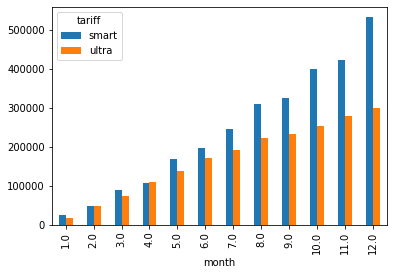

In [49]:
(data_total.
 pivot_table(index='month', columns='tariff', values='total_cost', aggfunc='sum')
.plot(kind='bar')
)

График помесячной выручки показывает устойчивый рост.

### Вывод

Была произведена подготовка данных для будущего анализа в два этапа. На певом этапе были изучены датасеты, приведены столбцы к нужным типам данных, удалены аномалии. На втором этапе были произведены необходимые расчеты и сформирована общая таблица, на которой будет основываться дальнейший анализ.

## Анализ данных

### Анализ поведения клиентов в зависимости от тарифного плана

<AxesSubplot:ylabel='tariff'>

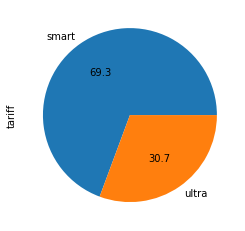

In [50]:
data_total['tariff'].value_counts().plot(kind='pie', autopct='%.1f')

Видим, что большинство клиентов в выборке используют тарифный план "Смарт".

In [51]:
data_total[data_total['tariff'] == 'smart'][['tariff_excess', 'total_cost']].describe()

,tariff_excess,total_cost
count,2230.000000,2230.000000
mean,739.641704,1289.641704
std,818.370799,818.370799
min,0.000000,550.000000
25%,0.000000,550.000000
50%,471.000000,1021.000000
75%,1200.000000,1750.000000
max,6220.000000,6770.000000


В среднем клиенты превышают тарифный план "Смарт" на 740 руб. Есть такие клиенты, которые укладываются в тариф, а есть те, кто платят сверху более 6000 руб. Средняя выручка по тарифу "Смарт" составляет 1290 руб.

In [52]:
data_total[data_total['tariff'] == 'ultra'][['tariff_excess', 'total_cost']].describe()

,tariff_excess,total_cost
count,986.000000,986.000000
mean,120.030426,2070.030426
std,376.015578,376.015578
min,0.000000,1950.000000
25%,0.000000,1950.000000
50%,0.000000,1950.000000
75%,0.000000,1950.000000
max,2850.000000,4800.000000


Для тарифного плана "Ультра" среднее превышение уже намного мемньше и составляет около 120 руб. Максимальное превышение составило 2850 руб. Средняя выручка по тарифу "Ультра" составляет 2070 руб.

<AxesSubplot:>

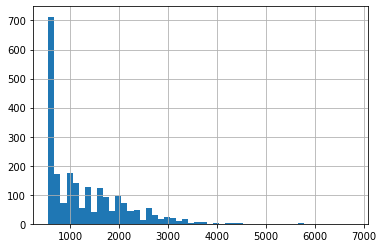

In [53]:
data_total[data_total['tariff'] == 'smart']['total_cost'].hist(bins=50)

Видим, что около 700 клиентов из 2229 укладываются в тарифный план "Смарт" и платят фиксированную сумму 550 руб. Остальные клиенты превышают тарифный план, но чем больше сумма, тем меньше клиентов. После отметки в 3000 руб. встречается совсем мало клиентов.

<AxesSubplot:>

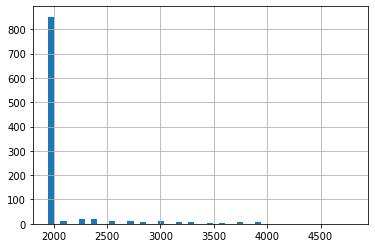

In [54]:
data_total[data_total['tariff'] == 'ultra']['total_cost'].hist(bins=50)

Здесь уже видим, что большинство клиентов (около 850 клиентов из 985) укладываются в тарифный план "Ультра". Есть клиенты, которые превышают тарифный план, но их немного, всего несколько десятков клиентов платят от 2000 руб. до 4000 руб. за тариф.

tariff
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: total_cost, dtype: object

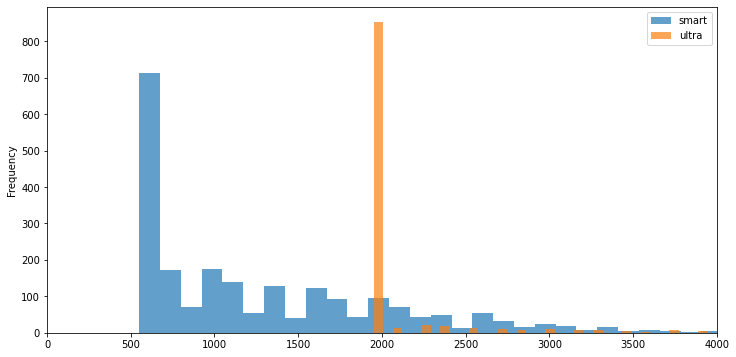

In [55]:
plt.xlim(0, 4000)
data_total.groupby('tariff')['total_cost'].plot(kind='hist', bins=50, figsize=(12, 6), legend=True, alpha=0.7)

### Расчеты и построение гистрограмм для каждого тарифного плана

#### Минуты разговора

In [56]:
# посчитаем среднее, дисперсию и стандартное отклонение
data_total.groupby('tariff').agg({'total_duration': ['mean', 'var', 'std']})

total_duration                           
                 mean            var         std
tariff                                          
smart      417.747534   36281.393836  190.476754
ultra      526.089249  101052.493549  317.887549

В среднем, пользователи тарифа "Смарт" выговаривают около 418 минут, что укладывается в тарифный план, а пользователи тарифа "Ультра" - около 527 минут. Для тарифа "Ультра" значения продолжительности звонков разбросаны сильнее, чем для тарифа "Смарт".

<AxesSubplot:>

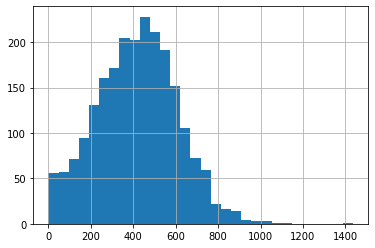

In [57]:
data_total[data_total['tariff'] == 'smart']['total_duration'].hist(bins=30)

<AxesSubplot:>

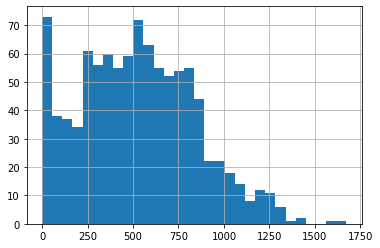

In [58]:
data_total[data_total['tariff'] == 'ultra']['total_duration'].hist(bins=30)

Видим распределение, близкое к нормальному. Второй график со смещением вправо. На обоих тарифах пики приходятся на значение около 500 минут.

#### Сообщения

In [59]:
# посчитаем среднее, дисперсию и стандартное отклонение
data_total.groupby('tariff').agg({'messages_per_month': ['mean', 'var', 'std']})

messages_per_month                        
                     mean          var        std
tariff                                           
smart           33.369058   796.955256  28.230396
ultra           49.313387  2285.417425  47.806040

В среднем, клиенты с тарифом "Смарт" расходуют около 33 сообщений и укладываются в абоненткую плату, а с тарифом "Ультра" - около 49 сообщений. Мера разброса значений для тарифа "Ультра" выше.

<AxesSubplot:>

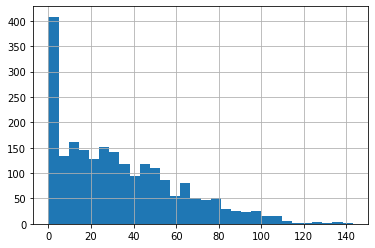

In [60]:
data_total[data_total['tariff'] == 'smart']['messages_per_month'].hist(bins=30)

<AxesSubplot:>

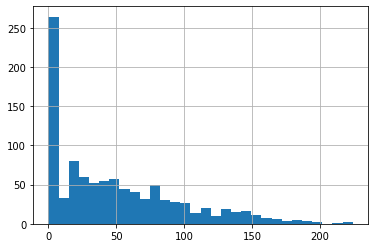

In [61]:
data_total[data_total['tariff'] == 'ultra']['messages_per_month'].hist(bins=30)

Видим распределение Пуассона. Пиковые значения приходятся на нули. Доказывает предположение, что смс теряют популярность. И все же несколько сотен клиентов тарифа "Смарт" умудряются превысить лимит в 50 сообщений.

#### Интернет

In [62]:
# посчитаем среднее, дисперсию и стандартное отклонение
data_total.groupby('tariff').agg({'mb_per_month': ['mean', 'var', 'std']})

mb_per_month                            
                mean           var           std
tariff                                          
smart   16201.118655  3.456484e+07   5879.187315
ultra   19449.059970  1.020321e+08  10101.095459

У пользователей тарифа "Смарт" уходит в среднем 15,8 гб. в месяц, что превышает тарифный план. Пользователи тарифа "Ультра" расходуют в среднем 19 гб. в месяц. Разброс значений у "Ультры" также выше.

<AxesSubplot:>

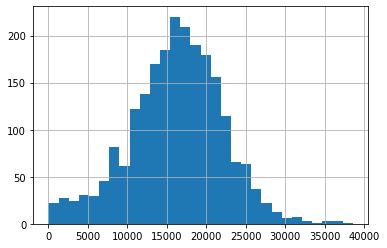

In [63]:
data_total[data_total['tariff'] == 'smart']['mb_per_month'].hist(bins=30)

<AxesSubplot:>

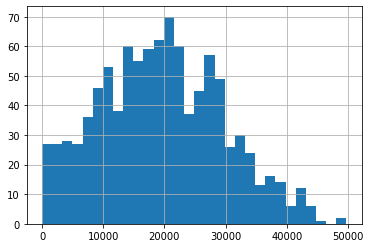

In [64]:
data_total[data_total['tariff'] == 'ultra']['mb_per_month'].hist(bins=30)

Видим нормальные распределения. На первом графике пик приходится на 15-16 тыс. мб. На втором графике несколько пиков, самый высокий приходится на 20 тыс. мб. Второй график также смещен вправо.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [65]:
ultra = data_total[data_total['tariff'] == 'ultra']
ultra = ultra['total_cost']
len(ultra)

986

In [66]:
smart = data_total[data_total['tariff'] == 'smart']
smart = smart['total_cost']
len(smart)

2230

У нас имеются две достаточно большие выборки, а значит выборочные средние распределены нормально. Достаточно большими считаются выборки более 30 элементов.  Будем проверять гипотезу о равенстве средних двух генеральных совокупностей, при условии, что выборки не зависят друг от друга. Т.к. выборки разного размера, предроложим, что дисперсии генеральных совокупностей не равны. Для проверки будем применять t-тест.
Нулевая гипотеза всегда содержит знак равенства. Сформулируем нулевую и альтернативную гипотезу:
* H0: Средняя выручка пользавателей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт";
* H1: Средняя выручка пользавателей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт".

In [67]:
# зададим критический уровень значимости
alpha = 0.05

In [68]:
results = st.ttest_ind(ultra, smart, equal_var = False)

In [69]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Проверка показала, что выручка по двум тарифам различается.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [70]:
data_total['city'].value_counts()

Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
                  ... 
Нижневартовск        6
Сургут               6
Химки                5
Кемерово             5
Иваново              2
Name: city, Length: 76, dtype: int64

In [71]:
moscow = data_total[data_total['city'] == 'Москва']
moscow = moscow['total_cost']
len(moscow)

611

In [72]:
other_cities = data_total[data_total['city'] != 'Москва']
other_cities = other_cities['total_cost']
len(other_cities)

2605

Будем также проверять гипотезу о равенстве средних. Сформулируем нулевую и альтернативную гипотезы:
* H0: Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;
* H1: Средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

In [73]:
results_2 = st.ttest_ind(moscow, other_cities, equal_var = False)

In [74]:
# оставим критический уровень значимости прежним
print('p-значение:', results_2.pvalue)

if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Значимых отличий выручки между Москвой и другими регионами нет.

## Общий вывод

Было проведено исследование по определению перспективного тарифного плана на основании выборки в 500 пользователей. В ходе исследования было выявлено, что большинство клиентов, а именно 69,4 % используют тарифный план "Смарт", а остальные 30,6 % являются пользователями тарифа "Ультра". Средняя месячная выручка с тарифа "Смарт" составляет 1290 руб., а с тарифа "Ультра" - 2070 руб.

Средний пользователь тарифа "Смарт" тратит около 418 минут разговора, 33 сообщений и 15,8 гб. интернета в месяц. Исходя из этого, средний пользователь тарифа "Смарт" не вписывается в тарифный план по количеству включенных гигабайт. В среднем пользователи этого тарифа доплачивают около 740 руб. сверху.

Средний пользователь тарифа "Ультра" расходует около 527 минут, 49 сообщений и 19 гб. в месяц. Из этого следует, что средний пользователь вписывается в тарифный план, но у него остается большой запас неизрасходованных минут, сообщений и гигабайт.

Для всей генеральной совокупности можно сделать вывод, что средние выручки пользователей тарифов "Смарт" и "Ультра" существенно отличаются. Что касается территориального расположения, то средняя выручка пользователей из Москвы не имеет значимых отличий от средней выручки пользователей из регионов.

Исходя из результатов, полученных при анализе, для среднего клиента тариф "Смарт" является более оптимальным, нежели тариф "Ультра". Для средних пользователей обоих тарифов, количество минут, смс и гигабайт не сильно отличаются, тогда как абонентская плата различаеся в 3.5 раза. Рекомендуется доработать тариф "Смарт", а именно увеличить количество включенных гигабайт, но при этом повысить стоимость тарифа в разумных пределах. Или, как вариант, создать новый тариф, который будет удовлетворять потребность пользователей в интернете, но не будет таким дорогим, как "Ультра".